In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

asdf


In [2]:
class TrackNetV2Encoder(nn.Module):
    def __init__(self):
        super(TrackNetV2Encoder, self).__init__()
        # Encoder layers (VGG-16 inspired)
        self.conv1 = nn.Sequential(
            nn.Conv2d(9, 64, 3, padding=1),  # 3 frames * 3 channels = 9 input channels
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Downsample to H/2, W/2
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Downsample to H/4, W/4
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Downsample to H/8, W/8
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Downsample to H/16, W/16
        )

    def forward(self, x):
        # x: (batch, 9, H, W) - 3 frames stacked
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        conv3_out = self.conv3(conv2_out)
        conv4_out = self.conv4(conv3_out)
        return conv4_out, [conv1_out, conv2_out, conv3_out]  # Return bottleneck and skip connections

class TrackNetV2Decoder(nn.Module):
    def __init__(self):
        super(TrackNetV2Decoder, self).__init__()
        # Decoder layers with upsampling and skip connections
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.ReLU()
        )
        self.conv_up4 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),  # 256 from up4 + 256 from conv3
            nn.ReLU()
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU()
        )
        self.conv_up3 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),  # 128 from up3 + 128 from conv2
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU()
        )
        self.conv_up2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),  # 64 from up2 + 64 from conv1
            nn.ReLU()
        )
        self.final = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 1)  # Output 3 heatmaps (one per frame)
        )

    def forward(self, x, skip_connections):
        # x: (batch, 512, H/16, W/16), skip_connections: [conv1, conv2, conv3]
        x = self.up4(x)
        x = torch.cat([x, skip_connections[2]], dim=1)  # Concat with conv3
        x = self.conv_up4(x)
        
        x = self.up3(x)
        x = torch.cat([x, skip_connections[1]], dim=1)  # Concat with conv2
        x = self.conv_up3(x)
        
        x = self.up2(x)
        x = torch.cat([x, skip_connections[0]], dim=1)  # Concat with conv1
        x = self.conv_up2(x)
        
        x = self.final(x)  # (batch, 3, H, W) - 3 heatmaps
        return x

In [3]:
class TrackNetV4(nn.Module):
    def __init__(self, theta_init=0.5):
        super(TrackNetV4, self).__init__()
        self.encoder = TrackNetV2Encoder()
        self.decoder = TrackNetV2Decoder()
        # Learnable parameter for power normalization
        self.theta = nn.Parameter(torch.tensor(theta_init, dtype=torch.float32))

    def generate_motion_attention_maps(self, frames):
        # frames: (batch, 9, H, W) -> split into 3 frames: (batch, 3, H, W) each
        batch_size, _, h, w = frames.shape
        frame1 = frames[:, 0:3, :, :]
        frame2 = frames[:, 3:6, :, :]
        frame3 = frames[:, 6:9, :, :]
        
        # Convert to grayscale (mean across channels)
        gray1 = frame1.mean(dim=1, keepdim=True)  # (batch, 1, H, W)
        gray2 = frame2.mean(dim=1, keepdim=True)
        gray3 = frame3.mean(dim=1, keepdim=True)
        
        # Compute absolute frame differences
        diff1 = torch.abs(gray2 - gray1)  # (batch, 1, H, W)
        diff2 = torch.abs(gray3 - gray2)
        
        # Power normalization with learnable theta
        motion_maps = torch.cat([diff1, diff2], dim=1)  # (batch, 2, H, W)
        motion_maps = torch.pow(motion_maps, self.theta)
        motion_maps = (motion_maps - motion_maps.min()) / (motion_maps.max() - motion_maps.min() + 1e-6)
        
        return motion_maps  # (batch, 2, H, W) - 2 motion maps

    def forward(self, x):
        # x: (batch, 9, H, W) - 3 frames stacked
        # Step 1: Generate motion attention maps
        motion_maps = self.generate_motion_attention_maps(x)  # (batch, 2, H, W)
        
        # Step 2: Encoder-Decoder to get visual features
        bottleneck, skip_connections = self.encoder(x)
        visual_features = self.decoder(bottleneck, skip_connections)  # (batch, 3, H, W)
        
        # Step 3: Motion-aware fusion
        fused_features = torch.zeros_like(visual_features)
        fused_features[:, 0, :, :] = visual_features[:, 0, :, :]  # First frame unchanged
        fused_features[:, 1, :, :] = visual_features[:, 1, :, :] * motion_maps[:, 0, :, :]  # Second frame
        fused_features[:, 2, :, :] = visual_features[:, 2, :, :] * motion_maps[:, 1, :, :]  # Third frame
        

        return fused_features

# Instantiate the model
model = TrackNetV4().to(device)

In [4]:


def generate_heatmap(center_x, center_y, h, w, sigma=5):
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    heatmap = np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * sigma ** 2))
    return heatmap / heatmap.max()

class TrackNetDataset(Dataset):
    def __init__(self, root_dir, target_size=(288, 512), transform=None):
        """
        Args:
            root_dir (str): Directory with all the frame folders.
            target_size (tuple): Desired (height, width) for images and heatmaps, e.g., (288, 512).
            transform (callable, optional): Optional transform to be applied on images.
        """
        self.root_dir = root_dir
        self.target_size = target_size  # New parameter for flexible image size
        self.transform = transform
        self.frame_folders = sorted([f for f in os.listdir(root_dir) if f.startswith('frame')])

        # Define the transform with the target size if none provided
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize(self.target_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.frame_folders)

    def __getitem__(self, idx):
        frame_folder = os.path.join(self.root_dir, self.frame_folders[idx])
        images = []
        heatmaps = []
        h, w = self.target_size  # Use the target size for heatmaps

        for i in range(3):  # Load 3 consecutive frames (image-0 to image-2)
            subfolder = os.path.join(frame_folder, f'image-{i}')
            img_path = os.path.join(subfolder, 'image.jpg')
            label_path = os.path.join(subfolder, 'label.txt')

            # Load image with fallback for missing files
            try:
                img = Image.open(img_path).convert('RGB')
            except FileNotFoundError:
                print(f"Image file {img_path} not found, using blank image")
                img = Image.fromarray(np.zeros((h, w, 3), dtype=np.uint8))  # Blank RGB image with target size
            if self.transform:
                img = self.transform(img)
            images.append(img)

            # Load and process label
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = f.readline().strip().split()
                    if not label:  # Empty file or only whitespace
                        heatmap = np.zeros((h, w))
                    elif len(label) >= 3:  # Valid YOLO format
                        try:
                            x_center = float(label[1]) * w  # Denormalize to target width
                            y_center = float(label[2]) * h  # Denormalize to target height
                            heatmap = generate_heatmap(x_center, y_center, h, w)
                        except (ValueError, IndexError) as e:
                            print(f"Error parsing label file {label_path}: {label}, Error: {e}")
                            heatmap = np.zeros((h, w))
                    else:
                        heatmap = np.zeros((h, w))
            else:
                heatmap = np.zeros((h, w))
            heatmaps.append(torch.tensor(heatmap, dtype=torch.float32))

        images = torch.cat(images, dim=0)  # (9, H, W), where H, W are from target_size
        heatmaps = torch.stack(heatmaps, dim=0)  # (3, H, W)
        return images, heatmaps

        
# Example usage
dataset = TrackNetDataset(root_dir='datasetf', target_size=(576, 1024))
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'datasetf'

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# Define the dataset split
dataset_size = len(dataset)
train_size = int(0.9 * dataset_size)  # 90% training
test_size = dataset_size - train_size  # 10% testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define loss function (BCEWithLogitsLoss with pos_weight)
pos_weight = torch.tensor([100]).to(device)  # Adjust if needed
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
best_loss = float('inf')
trigger_times = 0
patience = 5
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch_idx, (images, heatmaps) in enumerate(train_loader):
        images, heatmaps = images.to(device), heatmaps.to(device)
        
        # Forward pass (NO sigmoid here!)
        pred_heatmaps = model(images)

        # Compute loss
        loss = criterion(pred_heatmaps, heatmaps)
        total_train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_train_loss = total_train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}] Average Training Loss: {avg_train_loss:.4f}')

    # Evaluate on test dataset
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for images, heatmaps in test_loader:
            images, heatmaps = images.to(device), heatmaps.to(device)
            pred_heatmaps = model(images)
            loss = criterion(pred_heatmaps, heatmaps)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}] Average Testing Loss: {avg_test_loss:.4f}')

    # Early stopping check
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        trigger_times = 0  # Reset counter when improvement occurs
    else:
        trigger_times += 1
        print(f'No improvement in epoch {epoch+1} ({trigger_times}/{patience})')

    if trigger_times >= patience:
        print("Early stopping triggered.")
        break

# Save final model
torch.save(model.state_dict(), 'tracknetv4.pth')


Epoch [1/100], Batch [0/1001], Loss: 0.6878
Epoch [1/100], Batch [10/1001], Loss: 0.6832
Epoch [1/100], Batch [20/1001], Loss: 0.6285
Epoch [1/100], Batch [30/1001], Loss: 0.5046
Epoch [1/100], Batch [40/1001], Loss: 0.4846
Epoch [1/100], Batch [50/1001], Loss: 0.4169
Epoch [1/100], Batch [60/1001], Loss: 0.4154
Epoch [1/100], Batch [70/1001], Loss: 0.3983
Epoch [1/100], Batch [80/1001], Loss: 0.3896
Epoch [1/100], Batch [90/1001], Loss: 0.3753
Epoch [1/100], Batch [100/1001], Loss: 0.3842
Epoch [1/100], Batch [110/1001], Loss: 0.3942
Epoch [1/100], Batch [120/1001], Loss: 0.3973
Epoch [1/100], Batch [130/1001], Loss: 0.3194
Epoch [1/100], Batch [140/1001], Loss: 0.3697
Epoch [1/100], Batch [150/1001], Loss: 0.3482
Epoch [1/100], Batch [160/1001], Loss: 0.3259
Epoch [1/100], Batch [170/1001], Loss: 0.3598
Epoch [1/100], Batch [180/1001], Loss: 0.3233
Epoch [1/100], Batch [190/1001], Loss: 0.3751
Epoch [1/100], Batch [200/1001], Loss: 0.3071
Epoch [1/100], Batch [210/1001], Loss: 0.2992

In [10]:
model = TrackNetV4()
state_dict  = torch.load("tracknetv4.pth", weights_only=True, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

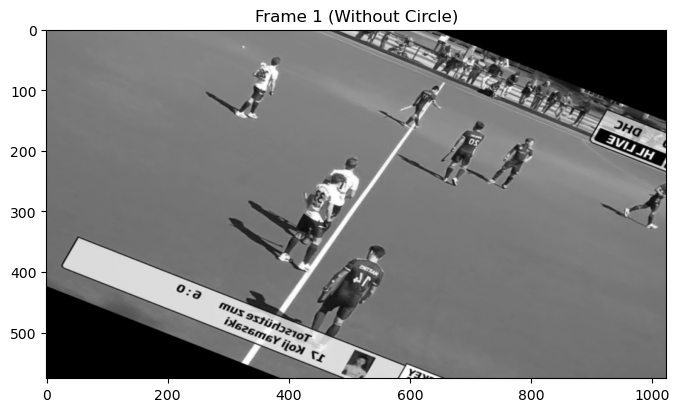

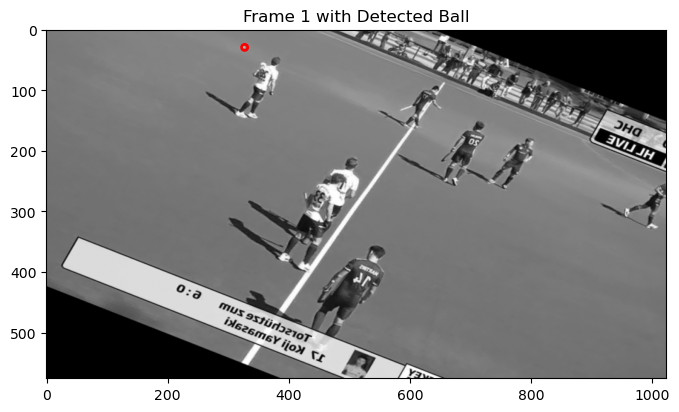

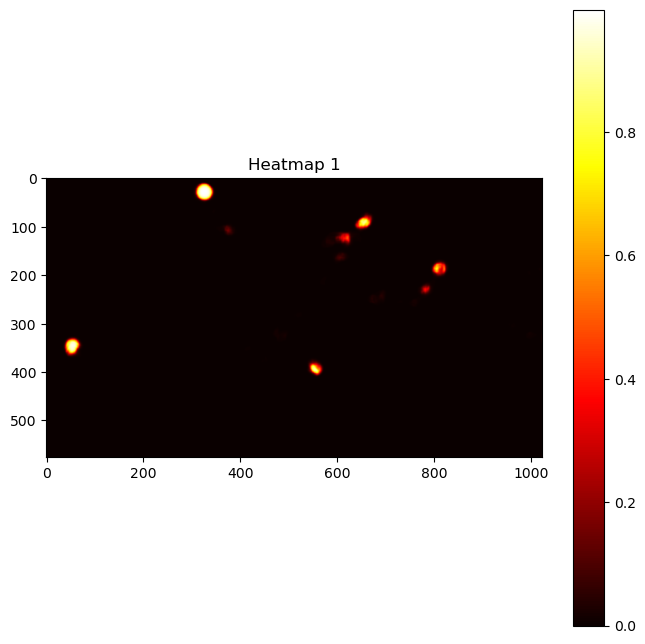

Frame 1 - Detected ball center: (x: 327, y: 29)


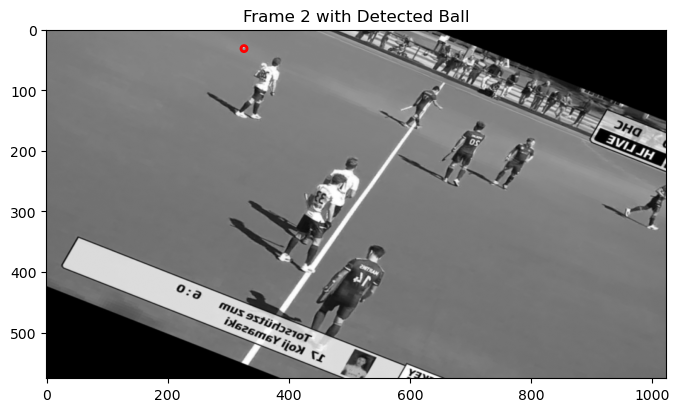

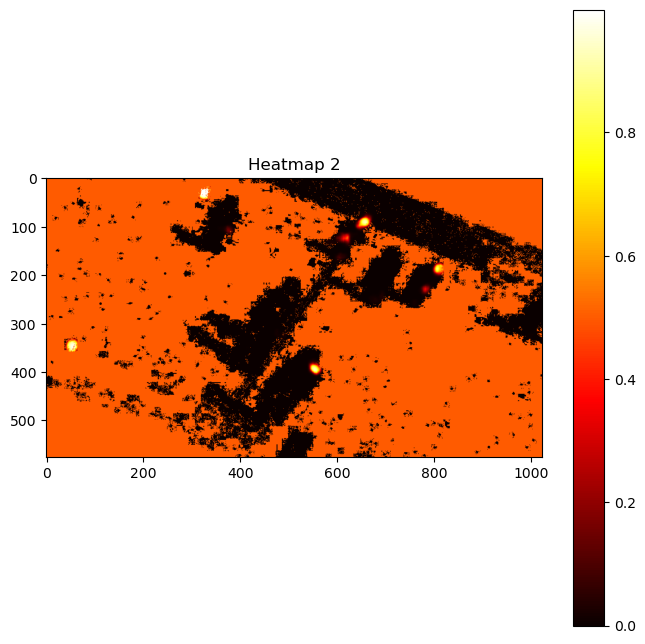

Frame 2 - Detected ball center: (x: 326, y: 31)


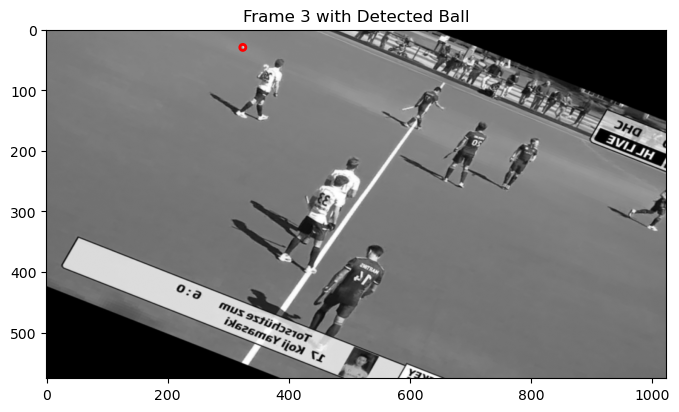

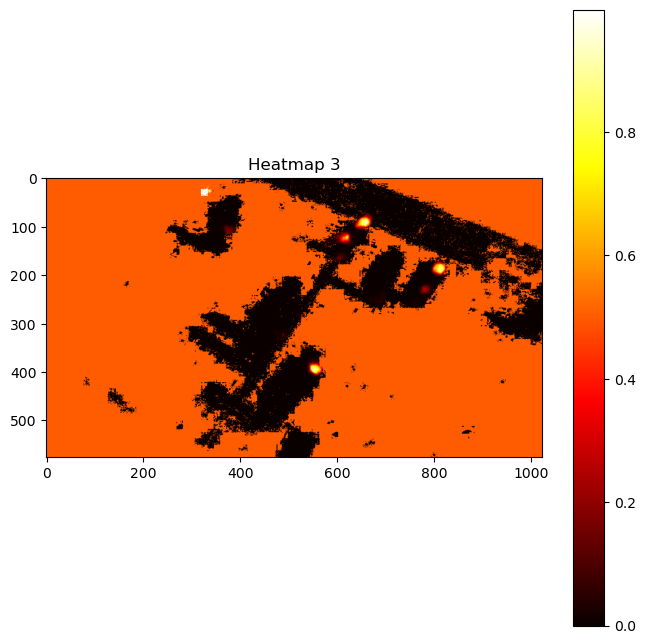

Frame 3 - Detected ball center: (x: 324, y: 29)


In [14]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    sample_images, sample_heatmaps = next(iter(dataloader))
    sample_images = sample_images.to(device)
    
    # Get raw logits from model
    pred_logits = model(sample_images)
    
    # Convert logits to probabilities
    pred_heatmaps = torch.sigmoid(pred_logits)  # Apply sigmoid

    # Process the first sample in the batch (index 0)
    for i in range(3):  # Loop over 3 frames
        # Get the frame and heatmap for this iteration
        frame = sample_images[0, i * 3:(i + 1) * 3].cpu()  # Shape: (3, H, W)
        heatmap = pred_heatmaps[0, i].cpu()  # Shape: (H, W)
        
        # Detect ball position (maximum value in heatmap)
        max_index = torch.argmax(heatmap)  # Get index of max probability
        h, w = heatmap.shape  # Get height and width of heatmap
        y, x = divmod(max_index.item(), w)  # Convert flat index to (x, y) coordinates
        
        # Show first frame without circle
        if i == 0:
            plt.figure(figsize=(8, 8))
            plt.imshow(frame.mean(dim=0), cmap='gray')  # Convert RGB to grayscale
            plt.title(f'Frame {i+1} (Without Circle)')
            plt.show()
        
        # Plot frame with detected ball position
        plt.figure(figsize=(8, 8))
        plt.imshow(frame.mean(dim=0), cmap='gray')  # Convert RGB to grayscale
        plt.title(f'Frame {i+1} with Detected Ball')

        # Add red circle at detected position
        plt.gca().add_patch(patches.Circle((x, y), radius=5, color='red', fill=False, linewidth=2))
        plt.show()
        
        # Plot heatmap for reference
        plt.figure(figsize=(8, 8))
        plt.imshow(heatmap, cmap='hot')
        plt.colorbar()
        plt.title(f'Heatmap {i+1}')
        plt.show()

        # Print detected coordinates
        print(f"Frame {i+1} - Detected ball center: (x: {x}, y: {y})")


In [11]:
import cv2
import torch
import numpy as np
from collections import deque

# Assuming model and device are already defined
# model = YourTrackNetV4Model()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
model.eval()

# Video input and output paths
input_video_path = 'test-tracking.mp4'
output_video_path = 'output_video.mp4'
heatmap_video_path = 'heatmap_video.mp4'

# Model input dimensions
MODEL_WIDTH = 1024
MODEL_HEIGHT = 576

# Original video dimensions
ORIGINAL_WIDTH = 1920
ORIGINAL_HEIGHT = 1080

# Scaling factors for coordinate mapping
SCALE_WIDTH = ORIGINAL_WIDTH / MODEL_WIDTH
SCALE_HEIGHT = ORIGINAL_HEIGHT / MODEL_HEIGHT

# Open the input video
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    raise ValueError("Error opening video file")

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = ORIGINAL_WIDTH
frame_height = ORIGINAL_HEIGHT

# Define the codec and create VideoWriter objects
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
heatmap_out = cv2.VideoWriter(heatmap_video_path, fourcc, fps, (MODEL_WIDTH, MODEL_HEIGHT))

# Buffer to hold 3 frames
frame_buffer = deque(maxlen=3)

# Function to prepare input tensor from 3 frames
def prepare_input(frames):
    tensor_list = []
    for frame in frames:
        resized_frame = cv2.resize(frame, (MODEL_WIDTH, MODEL_HEIGHT))
        rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
        frame_tensor = torch.from_numpy(rgb_frame).permute(2, 0, 1).float() / 255.0  # Shape: (3, 576, 1024)
        tensor_list.append(frame_tensor)
    input_tensor = torch.cat(tensor_list, dim=0)  # Shape: (9, 576, 1024)
    return input_tensor.unsqueeze(0).to(device)  # Shape: (1, 9, 576, 1024)

# Function to convert heatmap to color image
def heatmap_to_color_image(heatmap):
    # Normalize heatmap to [0, 255] and convert to uint8
    heatmap_np = heatmap.numpy()
    heatmap_normalized = cv2.normalize(heatmap_np, None, 0, 255, cv2.NORM_MINMAX)
    heatmap_uint8 = heatmap_normalized.astype(np.uint8)
    # Apply 'hot' colormap
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_HOT)
    return heatmap_color

# Process video frames
with torch.no_grad():
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # End of video
        
        # Add frame to buffer
        frame_buffer.append(frame)
        frame_count += 1

        # Process when we have 3 frames
        if len(frame_buffer) == 3:
            # Prepare input tensor
            input_tensor = prepare_input(frame_buffer)

            # Get heatmap from model (raw logits)
            heatmap = model(input_tensor)  # Shape: (1, 3, 576, 1024)

            # Apply Sigmoid to get probabilities
            heatmap_current = torch.sigmoid(heatmap[0, 1].cpu())  # Convert logits to probabilities

            # Apply thresholding (optional)
            threshold = 0.5
            heatmap_current = (heatmap_current > threshold).float() * heatmap_current

            # Find ball position in heatmap
            max_value, max_index = torch.max(heatmap_current.view(-1), dim=0)

            # Ignore low-confidence detections
            if max_value < 0.1:
                x_original, y_original = None, None
            else:
                y_resized, x_resized = divmod(max_index.item(), MODEL_WIDTH)
                x_original = int(round(x_resized * SCALE_WIDTH))
                y_original = int(round(y_resized * SCALE_HEIGHT))

            # Draw red circle on the middle frame if a valid ball position is found
            current_frame = frame_buffer[1].copy()  # Middle frame
            if x_original is not None and y_original is not None:
                cv2.circle(current_frame, (x_original, y_original), radius=10, color=(0, 0, 255), thickness=2)

            # Write the frame to output video
            out.write(current_frame)

            # Convert heatmap to color image and write to heatmap video
            heatmap_frame = heatmap_to_color_image(heatmap_current)
            heatmap_out.write(heatmap_frame)
        elif frame_count < 3:
            # Write original frame without detection for first two frames
            out.write(frame)
            # Write blank heatmap (black frame) for first two frames
            blank_heatmap = np.zeros((MODEL_HEIGHT, MODEL_WIDTH, 3), dtype=np.uint8)
            heatmap_out.write(blank_heatmap)

    # Handle remaining frames (if video length not multiple of 3)
    while len(frame_buffer) > 0:
        out.write(frame_buffer.popleft())
        blank_heatmap = np.zeros((MODEL_HEIGHT, MODEL_WIDTH, 3), dtype=np.uint8)
        heatmap_out.write(blank_heatmap)

# Release resources
cap.release()
out.release()
heatmap_out.release()
cv2.destroyAllWindows()

print(f"Detection video saved as {output_video_path}")
print(f"Heatmap video saved as {heatmap_video_path}")


KeyboardInterrupt: 

In [21]:
import cv2
import torch
import numpy as np
from collections import deque
import math

# Assuming model and device are already defined
# model = YourTrackNetV4Model()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
model.eval()

# Video input and output paths
input_video_path = 'test-video.mp4'
output_video_path = 'output_video.mp4'
heatmap_video_path = 'heatmap_video.mp4'

# Model input dimensions
MODEL_WIDTH = 1024
MODEL_HEIGHT = 576

# Original video dimensions
ORIGINAL_WIDTH = 1920
ORIGINAL_HEIGHT = 1080

# Scaling factors for coordinate mapping
SCALE_WIDTH = ORIGINAL_WIDTH / MODEL_WIDTH
SCALE_HEIGHT = ORIGINAL_HEIGHT / MODEL_HEIGHT

# Search window size in model coordinates (based on max movement estimate)
DELTA = 30  # ±30 pixels in model coordinates (~50 pixels in original scaled down)

# Open the input video
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    raise ValueError("Error opening video file")

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = ORIGINAL_WIDTH
frame_height = ORIGINAL_HEIGHT

# Define the codec and create VideoWriter objects
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
heatmap_out = cv2.VideoWriter(heatmap_video_path, fourcc, fps, (MODEL_WIDTH, MODEL_HEIGHT))

# Buffer to hold 3 frames
frame_buffer = deque(maxlen=3)

# Variables to store previous ball position in original coordinates
previous_x_original = None
previous_y_original = None

# Function to prepare input tensor from 3 frames
def prepare_input(frames):
    tensor_list = []
    for frame in frames:
        resized_frame = cv2.resize(frame, (MODEL_WIDTH, MODEL_HEIGHT))
        rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
        frame_tensor = torch.from_numpy(rgb_frame).permute(2, 0, 1).float() / 255.0
        tensor_list.append(frame_tensor)
    input_tensor = torch.cat(tensor_list, dim=0)
    return input_tensor.unsqueeze(0).to(device)

# Function to convert heatmap to color image
def heatmap_to_color_image(heatmap):
    heatmap_np = heatmap.numpy()
    heatmap_normalized = cv2.normalize(heatmap_np, None, 0, 255, cv2.NORM_MINMAX)
    heatmap_uint8 = heatmap_normalized.astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_HOT)
    return heatmap_color

# Process video frames
with torch.no_grad():
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # End of video
        
        # Add frame to buffer
        frame_buffer.append(frame)
        frame_count += 1

        # Process when we have 3 frames
        if len(frame_buffer) == 3:
            # Prepare input tensor
            input_tensor = prepare_input(frame_buffer)

            # Get heatmap from model (raw logits)
            heatmap = model(input_tensor)  # Shape: (1, 3, 576, 1024)

            # Apply Sigmoid to get probabilities for current frame
            heatmap_current = torch.sigmoid(heatmap[0, 1].cpu())

            # Apply thresholding (optional)
            threshold = 0.5
            heatmap_current = (heatmap_current > threshold).float() * heatmap_current

            # Determine ball position
            if previous_x_original is None or previous_y_original is None:
                # No previous position: use global maximum
                max_value, max_index = torch.max(heatmap_current.view(-1), dim=0)
                if max_value < 0.1:
                    x_original, y_original = None, None
                else:
                    y_resized, x_resized = divmod(max_index.item(), MODEL_WIDTH)
                    x_original = int(round(x_resized * SCALE_WIDTH))
                    y_original = int(round(y_resized * SCALE_HEIGHT))
            else:
                # Use search window based on previous position
                # Convert previous position to model coordinates
                x_model_prev = previous_x_original / SCALE_WIDTH
                y_model_prev = previous_y_original / SCALE_HEIGHT

                # Define search window bounds in model coordinates
                x_min = int(max(0, math.floor(x_model_prev - DELTA)))
                x_max = int(min(MODEL_WIDTH - 1, math.ceil(x_model_prev + DELTA)))
                y_min = int(max(0, math.floor(y_model_prev - DELTA)))
                y_max = int(min(MODEL_HEIGHT - 1, math.ceil(y_model_prev + DELTA)))

                # Extract heatmap region within search window
                heatmap_window = heatmap_current[y_min:y_max+1, x_min:x_max+1]

                # Find maximum within the window (fix for contiguous memory)
                max_value, max_index_window = torch.max(heatmap_window.contiguous().view(-1), dim=0)
                if max_value < 0.1:
                    x_original, y_original = None, None
                else:
                    # Convert window index to full heatmap coordinates
                    y_window, x_window = divmod(max_index_window.item(), heatmap_window.shape[1])
                    x_resized = x_min + x_window
                    y_resized = y_min + y_window
                    x_original = int(round(x_resized * SCALE_WIDTH))
                    y_original = int(round(y_resized * SCALE_HEIGHT))

            # Update previous position only if detection is valid
            if x_original is not None and y_original is not None:
                previous_x_original = x_original
                previous_y_original = y_original
            else:
                # Reset previous position if no detection to allow re-acquisition
                previous_x_original = None
                previous_y_original = None

            # Draw red circle on the middle frame if a valid ball position is found
            current_frame = frame_buffer[1].copy()  # Middle frame
            if x_original is not None and y_original is not None:
                cv2.circle(current_frame, (x_original, y_original), radius=10, color=(0, 0, 255), thickness=2)

            # Write the frame to output video
            out.write(current_frame)

            # Convert heatmap to color image and write to heatmap video
            heatmap_frame = heatmap_to_color_image(heatmap_current)
            heatmap_out.write(heatmap_frame)
        elif frame_count < 3:
            # Write original frame without detection for first two frames
            out.write(frame)
            blank_heatmap = np.zeros((MODEL_HEIGHT, MODEL_WIDTH, 3), dtype=np.uint8)
            heatmap_out.write(blank_heatmap)

    # Handle remaining frames
    while len(frame_buffer) > 0:
        out.write(frame_buffer.popleft())
        blank_heatmap = np.zeros((MODEL_HEIGHT, MODEL_WIDTH, 3), dtype=np.uint8)
        heatmap_out.write(blank_heatmap)

# Release resources
cap.release()
out.release()
heatmap_out.release()
cv2.destroyAllWindows()

print(f"Detection video saved as {output_video_path}")
print(f"Heatmap video saved as {heatmap_video_path}")

Detection video saved as output_video.mp4
Heatmap video saved as heatmap_video.mp4
